In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
data_file='/shared/obs/gridded/OISSTv2/monthly/sst.mnmean.nc'
ds_data=xr.open_dataset(data_file)
ds_data

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nbnds: 2, time: 461)
Coordinates:
  * lat        (lat) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2020-04-01
Dimensions without coordinates: nbnds
Data variables:
    sst        (time, lat, lon) float32 ...
    time_bnds  (time, nbnds) datetime64[ns] ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Wed Apr  6 13:47:45 2005: ncks -d time,0,278 SAVEs/sst.mn...
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V

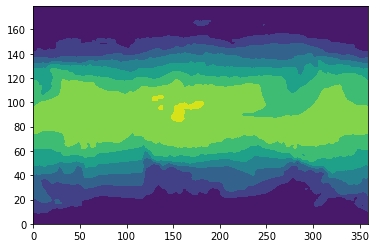

In [4]:
plt.contourf(ds_data['sst'][0,:,:])

In [5]:
mask_file='/shared/obs/gridded/OISSTv2/lmask/lsmask.nc'
ds_mask=xr.open_dataset(mask_file)
ds_mask

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-10-29
Data variables:
    mask     (time, lat, lon) float32 ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Created 10/2002 by RHS
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/

In [6]:
ds_mask['mask']

<xarray.DataArray 'mask' (time: 1, lat: 180, lon: 360)>
array([[[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-10-29
Attributes:
    long_name:    Land Sea Mask
    valid_range:  [0 1]
    units:        none
    dataset:      NOAA Optimum Interpolation (OI) SST V2
    var_desc:     Land-sea mask
    level_desc:   Surface
    statistic:    Other

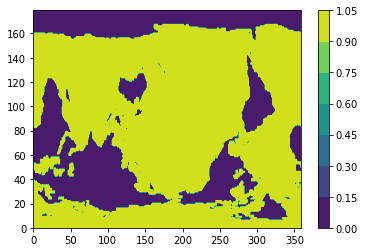

In [9]:
ds_mask=ds_mask.squeeze()
plt.contourf(ds_mask['mask'])
plt.colorbar()

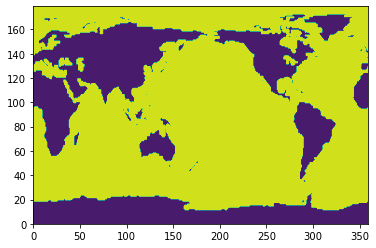

In [10]:
ds_mask=ds_mask.reindex(lat=list(reversed(ds_mask['lat'])))
ds_data=ds_data.reindex(lat=list(reversed(ds_data['lat'])))
plt.contourf(ds_mask['mask'])

In [11]:
da_ocean=ds_data['sst'].mean(dim='time').where(ds_mask['mask']==1)
da_ocean

<xarray.DataArray 'sst' (lat: 180, lon: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-1.7711465, -1.7700399, -1.7696716, ..., -1.7753105, -1.7753539,
        -1.7750288],
       [-1.7899934, -1.7899934, -1.7899934, ..., -1.7899934, -1.7899934,
        -1.7899934],
       [-1.7899934, -1.7899934, -1.7899934, ..., -1.7899934, -1.7899934,
        -1.7899934]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    time     datetime64[ns] 1981-10-29

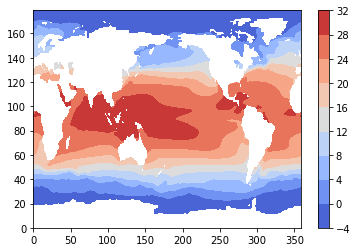

In [12]:
plt.contourf(da_ocean,cmap='coolwarm')
plt.colorbar()